In [1]:
# !!pip install pip install torchmetrics

Load the Dataset into a Dataloader

In [46]:
from glob import glob
import os
from torchvision import transforms, datasets
import torch


data_transform = transforms.Compose([
    # transforms.RandomCrop(200)
        transforms.Resize((32, 32)),
        # transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        # transforms.Normalize(mean=[0.485, 0.456, 0.406],
        #                      std=[0.229, 0.224, 0.225]),
    ])

train_data = datasets.ImageFolder(root='./data/animals_dataset/Train',
                                           transform=data_transform
                                           )
train_loader = torch.utils.data.DataLoader(train_data,
                                             batch_size=128, shuffle=True,
                                             num_workers=4)

test_data = datasets.ImageFolder(root='./data/animals_dataset/Test',
                                           transform=data_transform
                                           )
test_loader = torch.utils.data.DataLoader(test_data,
                                             batch_size=128, shuffle=True,
                                             num_workers=4)


classes = ('Caballo', 'Elefante', 'Gato', 'Oveja','Perro')

Define some classes weights for balancing in the loss function

In [22]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


In [4]:

torch.__version__
# !conda update pytorch torchvision

'2.0.0.dev20230212'

In [23]:
train_iter = list(iter(train_loader))

In [24]:
train_iter[0][0].shape

torch.Size([128, 3, 32, 32])

In [47]:
from glob import glob
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

classes_counts = np.array([])

for data, labels in train_iter:
    classes_counts = np.hstack((classes_counts, labels))

print(classes_counts.shape)
weights = compute_class_weight(class_weight='balanced', classes=np.unique(classes_counts), y=classes_counts)
print(weights)


(5610,)
[0.84935655 2.11299435 1.75039002 1.59375    0.46498135]


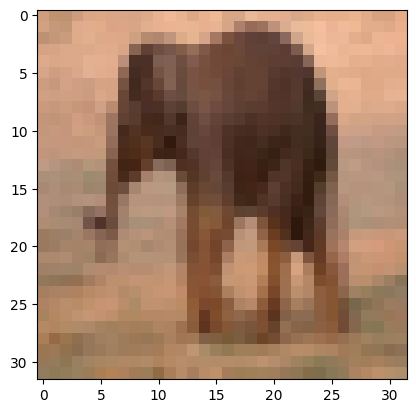

In [48]:
import matplotlib.pyplot as plt
plt.imshow(train_data[1700][0].permute(1, 2, 0))

Deficnition of our CNN

https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html

https://github.com/vdumoulin/conv_arithmetic/blob/master/README.md

https://arxiv.org/abs/1603.07285

In [6]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super().__init__()
        # Input shape (n, 3, h, w) h = 200, w = 200 
        self.conv1 = nn.Conv2d(3, 12, 21) # Output shape  (n, 12, h - (21-1), w - (21-1)) = (n,12,h-20, w-20) = (n, 12, 180, 180)
        # Cross-correlation taking maximum over specified windows. Arithmetics are the sames as conv2d
        # By default the stride in both dims is kernel size, so pooling windows don't overlap
        self.pool = nn.MaxPool2d(2, 2) # Output (n, 12, H2/2, W2/2)  = (n, 12, 90, 90) 1st; (n, 16, 35, 35) 2nd
        self.conv2 = nn.Conv2d(12, 16, 21) # Output (n, 16, H3 - 20, W3 - 20) = (n, 16, 70, 70)
        self.bn1 = nn.BatchNorm2d(12)
        self.bn2 = nn.BatchNorm2d(16)
        self.fc1 = nn.Linear(16 * 35 * 35, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 5) 

    def forward(self, x):
        x = self.pool(self.bn1(F.relu(self.conv1(x))))
        x = self.pool(self.bn2(F.relu(self.conv2(x))))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()

# Lets write it in pytorch lightnning format

In [49]:
import pytorch_lightning as pl
from typing import Any
import torch.nn.functional as F
import torch.nn as nn
from torch import optim
import torchmetrics as tm
from torch.utils.tensorboard import SummaryWriter

# default `log_dir` is "runs" - we'll be more specific here
writer = SummaryWriter('./logs/runs/')

class ConvNetPL(pl.LightningModule):
    def __init__(self, weights, lr, wd,*args: Any, **kwargs: Any) -> None:
        super().__init__(*args, **kwargs)
        self.weights = torch.from_numpy(weights).to(torch.float32)
        self.lr = lr
        self.wd = wd
        self.train_acc = tm.Accuracy(task='multiclass', num_classes=len(weights))
        self.valid_acc = tm.Accuracy(task="multiclass", num_classes=len(weights))

        self.save_hyperparameters()

        self.main_model = nn.Sequential(
            nn.Conv2d(3,32,kernel_size=3,padding=1),
            nn.ReLU(),
            nn.Conv2d(32,64,kernel_size=3,stride=1,padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2,2),

            nn.Conv2d(64,128,kernel_size=3,stride=1,padding=1),
            nn.ReLU(),
            nn.Conv2d(128,128,kernel_size=3,stride=1,padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2,2),

            nn.Conv2d(128,256,kernel_size=3,stride=1,padding=1),
            nn.ReLU(),
            nn.Conv2d(256,256,kernel_size=3,stride=1,padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2,2),

            nn.Flatten(),
            nn.Linear(256*4*4,512),
            nn.ReLU(),
            nn.Linear(512,256),
            nn.ReLU(),
            nn.Linear(256,5)
        )

    def training_step(self, batch, batch_idx):
        # training_step defines the train loop.
        # it is independent of forward
        x, y = batch
        x_hat = self.main_model(x)
        # print(x_hat.dtype, y.dtype, self.weights.dtype)
        loss = F.cross_entropy(x_hat, y, weight=self.weights)
        # Logging to TensorBoard (if installed) by default
        self.log("train_loss", loss)
        
        # log step metric
        self.train_acc(x_hat, y)
        self.log('train_acc_step', self.train_acc, on_step=True, on_epoch=False)
        return loss

    def training_epoch_end(self, outs):
        # log epoch metric
        self.log('train_acc_epoch', self.train_acc)

    def validation_step(self, batch, batch_idx):
        x, y = batch
        logits = self.main_model(x)
        self.valid_acc(logits, y)
        self.log('valid_acc', self.valid_acc, on_step=True, on_epoch=True)

    def configure_optimizers(self):
        optimizer = optim.Adam(self.parameters(), lr=self.lr, weight_decay=self.wd)
        return optimizer



In [50]:
model_pl = torch.compile(ConvNetPL(weights, lr=1e-3, wd=0))

c:\Users\diego\anaconda3\envs\torch_last\lib\site-packages\torch\_dynamo\eval_frame.py:409: UserWarning: Windows is not currently supported, torch.compile() will do nothing
  warnings.warn(


In [22]:
images[0].permute(1,2,0).shape

torch.Size([32, 32, 3])

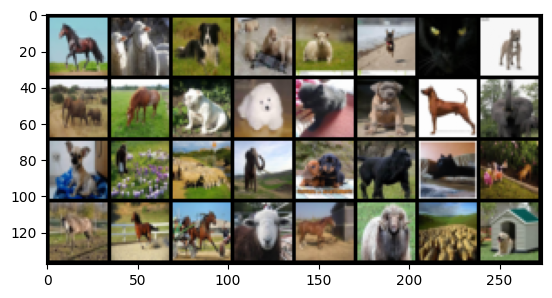

In [24]:
from torchvision.utils import make_grid

# get some random training images
images, labels = train_iter[0]

# create grid of images
img_grid = make_grid(images).permute(1,2,0)

# show images
# print images
plt.imshow(img_grid)

# write to tensorboard
writer.add_image('32_data_images', images[0].numpy())
# writer.add_graph(model_pl, images)

In [51]:
from pytorch_lightning.utilities.model_summary import ModelSummary

ModelSummary(model_pl, max_depth=-1)  

   | Name          | Type               | Params
------------------------------------------------------
0  | train_acc     | MulticlassAccuracy | 0     
1  | valid_acc     | MulticlassAccuracy | 0     
2  | main_model    | Sequential         | 3.4 M 
3  | main_model.0  | Conv2d             | 896   
4  | main_model.1  | ReLU               | 0     
5  | main_model.2  | Conv2d             | 18.5 K
6  | main_model.3  | ReLU               | 0     
7  | main_model.4  | MaxPool2d          | 0     
8  | main_model.5  | Conv2d             | 73.9 K
9  | main_model.6  | ReLU               | 0     
10 | main_model.7  | Conv2d             | 147 K 
11 | main_model.8  | ReLU               | 0     
12 | main_model.9  | MaxPool2d          | 0     
13 | main_model.10 | Conv2d             | 295 K 
14 | main_model.11 | ReLU               | 0     
15 | main_model.12 | Conv2d             | 590 K 
16 | main_model.13 | ReLU               | 0     
17 | main_model.14 | MaxPool2d          | 0     
18 | main_mode

In [52]:
# no accumulation for epochs 1-4. accumulate 3 for epochs 5-10. accumulate 20 after that
# accumulate_grad_batches={5: 3, 10: 20},
trainer = pl.Trainer( max_epochs=30, default_root_dir="./logs/checkpoints/",  log_every_n_steps=10)
trainer.fit(model=model_pl, train_dataloaders=train_loader,  val_dataloaders=test_loader)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name       | Type               | Params
--------------------------------------------------
0 | train_acc  | MulticlassAccuracy | 0     
1 | valid_acc  | MulticlassAccuracy | 0     
2 | main_model | Sequential         | 3.4 M 
--------------------------------------------------
3.4 M     Trainable params
0         Non-trainable params
3.4 M     Total params
13.425    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

c:\Users\diego\anaconda3\envs\torch_last\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:488: PossibleUserWarning: Your `val_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test/predict dataloaders.
  rank_zero_warn(


Epoch 29: 100%|██████████| 66/66 [01:14<00:00,  1.13s/it, loss=0.0972, v_num=13]

`Trainer.fit` stopped: `max_epochs=30` reached.


Epoch 29: 100%|██████████| 66/66 [01:15<00:00,  1.14s/it, loss=0.0972, v_num=13]


In [20]:
# %reload_ext tensorboard
# %tensorboard --logdir=logs/checkpoints/lightning_logs/

Optimizer and Loss

In [7]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss(classes_weights.to(device))
optimizer = optim.Adam(net.parameters(), lr=0.0015)

Training Loop

In [8]:
loder_len = len(train_loader)

In [9]:
net.to(device)

Net(
  (conv1): Conv2d(3, 12, kernel_size=(21, 21), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(12, 16, kernel_size=(21, 21), stride=(1, 1))
  (bn1): BatchNorm2d(12, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=19600, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=5, bias=True)
)

In [10]:
%%time
from tqdm import tqdm
losses = []
avg_losses = []
for epoch in range(10):  # loop over the dataset multiple times

    running_loss = 0.0
    avg_loss = 0.0
    with tqdm(enumerate(train_loader, 0), total=loder_len) as tepoch:
        for i, data in tepoch:
            tepoch.set_description(f"Epoch {epoch}.  ")

            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data[0].to(device), data[1].to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # print statistics
            losses.append(loss.item())
            running_loss += loss.item()

            if i % 50 == 49:    # print every 50 mini-batches
                tepoch.set_postfix(loss=f'{running_loss / 50:.3f}')
                running_loss = 0.0
        
        avg_losses.append(running_loss / len(train_loader))



print('Finished Training')

Epoch 9.  : 100%|██████████| 1403/1403 [06:33<00:00,  3.57it/s, loss=0.695]

Finished Training
CPU times: total: 1h 17min 18s
Wall time: 1h 18min 54s


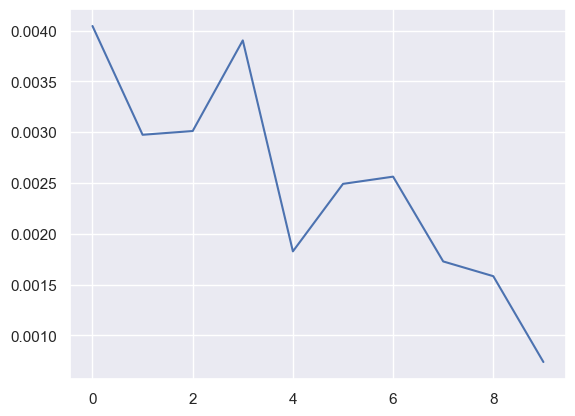

In [15]:
import seaborn as sns
sns.set_theme()
plt.plot(avg_losses)

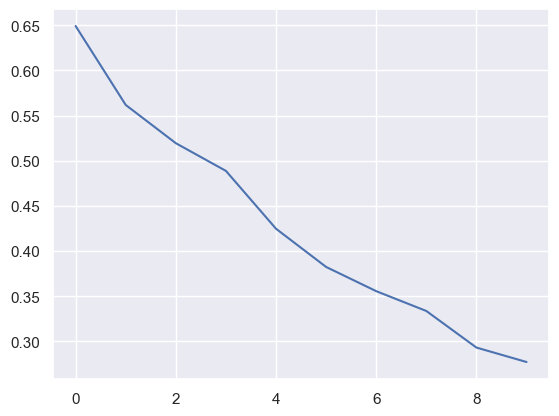

In [31]:
epoch_losses = []
s = len(losses) // 10
for i in range(10):
    avg_loss = sum(losses[i * s: (i+1)*s]) / s
    epoch_losses.append(avg_loss)

plt.plot(epoch_losses)

In [14]:
PATH = './models/animals_4.pth'
torch.save(net.state_dict(), PATH)

Test

GroundTruth:  Perro Elefante Perro Perro


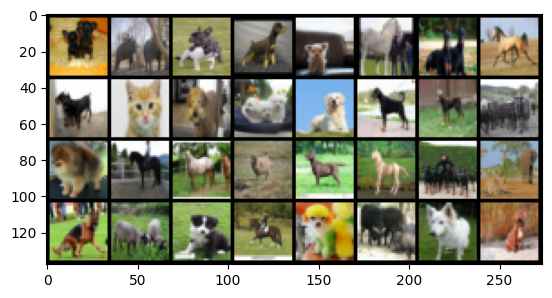

In [13]:
from torchvision.utils import make_grid

# test_iter = iter(test_loader)
images, labels = train_iter[0]

# print images
plt.imshow(make_grid(images).permute(1,2,0))
print('GroundTruth: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))

In [17]:
net = Net()
net.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [18]:
outputs = net(images)

In [14]:
outputs = model_pl.main_model(images)

In [15]:
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join(f'{classes[predicted[j]]:5s}'
                              for j in range(32)))
                              

Predicted:  Gato  Elefante Perro Perro Perro Caballo Perro Caballo Perro Gato  Perro Perro Perro Perro Perro Oveja Elefante Caballo Caballo Oveja Perro Caballo Perro Elefante Perro Oveja Perro Caballo Perro Oveja Perro Perro


In [16]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        # calculate outputs by running images through the network
        outputs = model_pl.main_model(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

Accuracy of the network on the 10000 test images: 54 %


In [19]:
# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# again no gradients needed
with torch.no_grad():
    for data in train_loader:
        images, labels = data
        outputs = model_pl.main_model(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

Accuracy for class: Caballo is 97.4 %
Accuracy for class: Elefante is 100.0 %
Accuracy for class: Gato  is 96.7 %
Accuracy for class: Oveja is 98.3 %
Accuracy for class: Perro is 94.2 %


Accuracy of classes without manual weight for cross entropy loss


![Alt text](./imgs/no_weights_accuracy.png)


Accuracy of classes with manual weights

![Alt text](./imgs/with_weights_accuracy.png)